In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.
import kagglehub
robinreni_signature_verification_dataset_path = kagglehub.dataset_download('robinreni/signature-verification-dataset')

print('Data source import complete.')


100%|██████████| 601M/601M [00:06<00:00, 101MB/s] 

Extracting files...


Data source import complete.


In [5]:


import os


if 'robinreni_signature_verification_dataset_path' in locals():
  print(robinreni_signature_verification_dataset_path)
  dataset_path = robinreni_signature_verification_dataset_path

  # Check if the path exists, if not, print an error
  if os.path.exists(dataset_path):
    print(f"The dataset path is: {dataset_path}")
    # List the files within the directory (optional)
    # for filename in os.listdir(dataset_path):
    #    print(os.path.join(dataset_path, filename))

  else:
      print(f"Error: Dataset path '{dataset_path}' not found. Please ensure the kaggle dataset was downloaded correctly.")
else:
    print("Error: 'robinreni_signature_verification_dataset_path' is not defined. Please run the provided code snippet first.")


/root/.cache/kagglehub/datasets/robinreni/signature-verification-dataset/versions/2
The dataset path is: /root/.cache/kagglehub/datasets/robinreni/signature-verification-dataset/versions/2



Initializing training dataset...

Analyzing directory: /root/.cache/kagglehub/datasets/robinreni/signature-verification-dataset/versions/2/sign_data/sign_data/train
Found genuine folders: ['029', '001', '036', '017', '038', '041', '067', '046', '069', '044', '034', '063', '045', '024', '002', '055', '033', '026', '064', '031', '066', '012', '052', '004', '035', '003', '037', '065', '016', '039', '025', '040', '048', '047', '009', '062', '023', '020', '013', '006', '057', '032', '043', '027', '056', '028', '059', '051', '050', '053', '060', '049', '018', '022', '061', '021', '019', '014', '015', '068', '030', '042', '054', '058']

Folder 029:
  Genuine images: 12
  Forged images: 12

Folder 001:
  Genuine images: 24
  Forged images: 8

Folder 036:
  Genuine images: 12
  Forged images: 12

Folder 017:
  Genuine images: 12
  Forged images: 12

Folder 038:
  Genuine images: 12
  Forged images: 12

Folder 041:
  Genuine images: 12
  Forged images: 12

Folder 067:
  Genuine images: 12
  For

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 150MB/s]


Epoch 0/9, Train Loss: 0.0314, Train Acc: 0.9868, Val Loss: 0.1467, Val Acc: 0.9622
Confusion Matrix (Epoch 0):
[[2976    0]
 [ 165 1221]]
Epoch 1/9, Train Loss: 0.0006, Train Acc: 0.9999, Val Loss: 0.0598, Val Acc: 0.9810
Confusion Matrix (Epoch 1):
[[5952    0]
 [ 248 2524]]
Epoch 2/9, Train Loss: 0.0000, Train Acc: 1.0000, Val Loss: 0.0047, Val Acc: 0.9986
Confusion Matrix (Epoch 2):
[[8928    0]
 [ 254 3904]]
Epoch 3/9, Train Loss: 0.0000, Train Acc: 1.0000, Val Loss: 0.0065, Val Acc: 0.9986
Confusion Matrix (Epoch 3):
[[11904     0]
 [  260  5284]]
Epoch 4/9, Train Loss: 0.0000, Train Acc: 1.0000, Val Loss: 0.0021, Val Acc: 0.9986
Confusion Matrix (Epoch 4):
[[14880     0]
 [  266  6664]]
Epoch 5/9, Train Loss: 0.0000, Train Acc: 1.0000, Val Loss: 0.0068, Val Acc: 0.9986
Early stopping


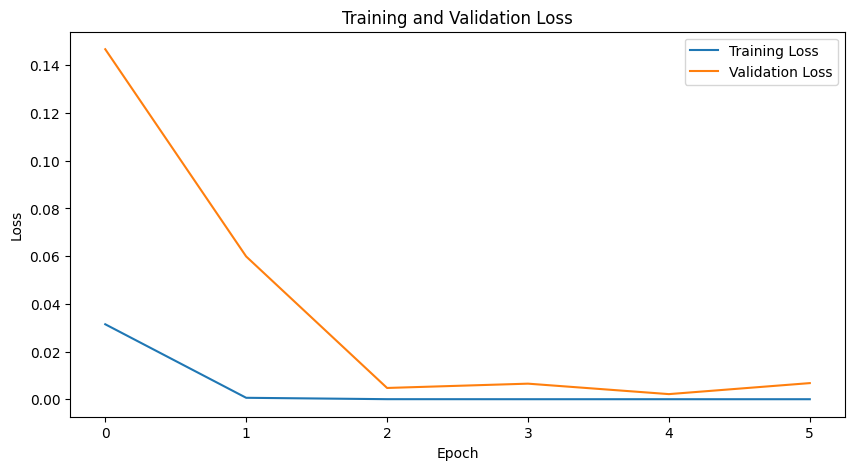

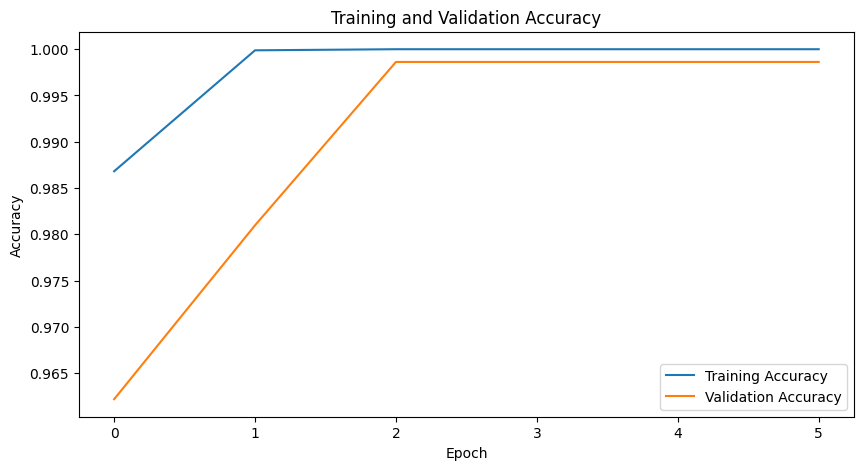

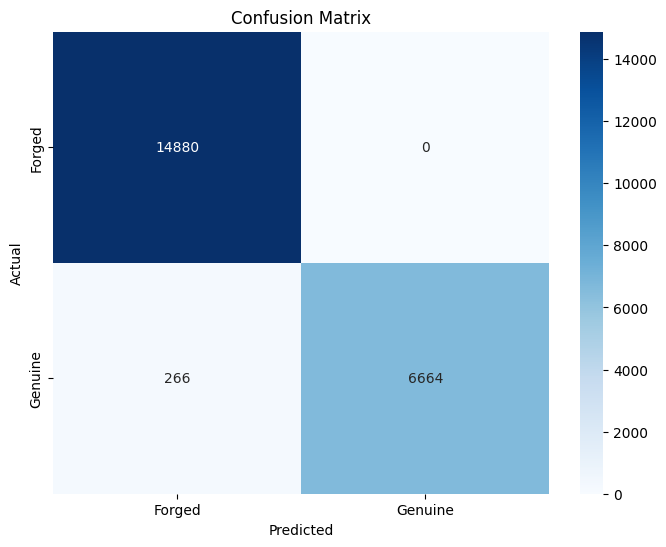

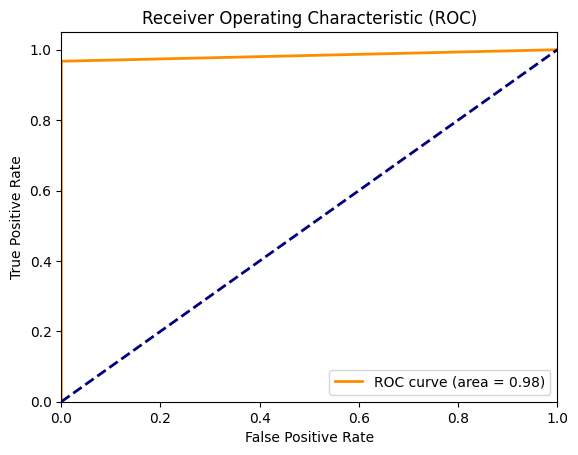


Best validation accuracy achieved: 1.00%


In [6]:
import torch
import torch.nn as nn
import torchvision.models as models
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve, auc, confusion_matrix, accuracy_score
import numpy as np
from PIL import Image
import os
from torch.optim import Adam
import copy

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class SignatureDataset(Dataset):
    def __init__(self, root_dir, subset='train', transform=None):
        self.root_dir = os.path.join(root_dir, subset)
        self.transform = transform

        # Verify root directory exists
        if not os.path.exists(self.root_dir):
            raise ValueError(f"Directory not found: {self.root_dir}")

        print(f"\nAnalyzing directory: {self.root_dir}")
        self.pairs = self._create_pairs()
        print(f"Total pairs created: {len(self.pairs)}")

        if len(self.pairs) == 0:
            print(f"\nDirectory structure for {self.root_dir}:")
            self._print_directory_structure(self.root_dir)
            raise ValueError(f"No valid pairs found in {self.root_dir}")

    def _print_directory_structure(self, startpath):
        for root, dirs, files in os.walk(startpath):
            level = root.replace(startpath, '').count(os.sep)
            indent = ' ' * 4 * level
            print(f'{indent}{os.path.basename(root)}/')
            subindent = ' ' * 4 * (level + 1)
            for f in files:
                if f.endswith(('.png', '.jpg', '.jpeg')):
                    print(f'{subindent}{f}')

    def _create_pairs(self):
        pairs = []
        genuine_folders = []

        # Get all subdirectories
        for item in os.listdir(self.root_dir):
            if os.path.isdir(os.path.join(self.root_dir, item)):
                if not item.endswith('_forg'):
                    genuine_folders.append(item)

        print(f"Found genuine folders: {genuine_folders}")

        for folder in genuine_folders:
            genuine_path = os.path.join(self.root_dir, folder)
            forged_path = os.path.join(self.root_dir, f"{folder}_forg")

            if not os.path.exists(forged_path):
                print(f"Warning: No forged folder found for {folder}")
                continue

            # Get genuine and forged images
            genuine_images = [f for f in os.listdir(genuine_path)
                            if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
            forged_images = [f for f in os.listdir(forged_path)
                           if f.lower().endswith(('.png', '.jpg', '.jpeg'))]

            print(f"\nFolder {folder}:")
            print(f"  Genuine images: {len(genuine_images)}")
            print(f"  Forged images: {len(forged_images)}")

            # Create genuine pairs
            for i in range(len(genuine_images)):
                for j in range(i + 1, len(genuine_images)):
                    pairs.append((
                        os.path.join(genuine_path, genuine_images[i]),
                        os.path.join(genuine_path, genuine_images[j]),
                        1  # genuine pair
                    ))

            # Create forged pairs
            for genuine_img in genuine_images:
                for forged_img in forged_images:
                    pairs.append((
                        os.path.join(genuine_path, genuine_img),
                        os.path.join(forged_path, forged_img),
                        0  # forged pair
                    ))

        return pairs

    def __len__(self):
        return len(self.pairs)

    def __getitem__(self, idx):
        img1_path, img2_path, label = self.pairs[idx]

        try:
            img1 = Image.open(img1_path).convert('RGB')
            img2 = Image.open(img2_path).convert('RGB')

            # Check if the image contains a signature by looking for minimum content (e.g., black pixels)
            if np.sum(np.array(img1) < 240) < 1000 or np.sum(np.array(img2) < 240) < 1000:  # Threshold for detecting if image is too light to be a signature
                raise ValueError("Image does not contain a signature")

            if self.transform:
                img1 = self.transform(img1)
                img2 = self.transform(img2)
        except (ValueError, IOError) as e:
            print(f"Error processing images: {e}")
            return torch.zeros_like(torch.zeros(3, 224, 224)), torch.zeros_like(torch.zeros(3, 224, 224)), torch.FloatTensor([-1])  # Return placeholder tensors and error label

        return img1, img2, torch.FloatTensor([label])

class SiameseNetwork(nn.Module):
    def __init__(self):
        super(SiameseNetwork, self).__init__()
        self.cnn = models.resnet50(pretrained=True)
        self.cnn.fc = nn.Linear(self.cnn.fc.in_features, 256)  # Adjust if necessary for ResNet50 output size

        self.fc1 = nn.Sequential(
            nn.Linear(256 * 2, 512),
            nn.ReLU(inplace=True),
            nn.Linear(512, 1),
            nn.Sigmoid()
        )

    def forward(self, img1, img2):
        feat1 = self.cnn(img1)
        feat2 = self.cnn(img2)
        combined = torch.cat((feat1, feat2), 1)
        output = self.fc1(combined)
        return output

def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs, patience, all_labels, all_preds):
    best_accuracy = 0.0
    best_model_wts = copy.deepcopy(model.state_dict())
    train_losses, val_losses, train_accs, val_accs = [], [], [], []

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        for img1, img2, labels in train_loader:
            img1, img2, labels = img1.to(device), img2.to(device), labels.to(device)
            # Ensure valid_mask is 1D
            valid_mask = (labels != -1).squeeze()  # Convert to 1D tensor

            if valid_mask.any():
                outputs = model(img1[valid_mask], img2[valid_mask])
                loss = criterion(outputs, labels[valid_mask])
                loss.backward()
                optimizer.step()
                optimizer.zero_grad()
                running_loss += loss.item() * valid_mask.sum().item()

                predicted = (outputs > 0.5).float()
                correct += (predicted == labels[valid_mask]).sum().item()
                total += valid_mask.sum().item()

        train_loss = running_loss / total if total > 0 else 0
        train_acc = correct / total if total > 0 else 0
        train_losses.append(train_loss)
        train_accs.append(train_acc)

        # Validation
        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0

        with torch.no_grad():
            for img1, img2, labels in val_loader:
                img1, img2, labels = img1.to(device), img2.to(device), labels.to(device)
                # Ensure valid_mask is 1D
                valid_mask = (labels != -1).squeeze()  # Convert to 1D tensor

                if valid_mask.any():
                    outputs = model(img1[valid_mask], img2[valid_mask])
                    loss = criterion(outputs, labels[valid_mask])
                    val_loss += loss.item() * valid_mask.sum().item()

                    predicted = (outputs > 0.5).float()
                    val_correct += (predicted == labels[valid_mask]).sum().item()
                    val_total += valid_mask.sum().item()

                    all_labels.extend(labels[valid_mask].cpu().numpy())
                    all_preds.extend(predicted.cpu().numpy())

        val_loss = val_loss / val_total if val_total > 0 else 0
        val_acc = val_correct / val_total if val_total > 0 else 0
        val_losses.append(val_loss)
        val_accs.append(val_acc)

        print(f'Epoch {epoch}/{num_epochs - 1}, '
              f'Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, '
              f'Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}')

        # Early stopping
        if val_acc > best_accuracy:
            best_accuracy = val_acc
            best_model_wts = copy.deepcopy(model.state_dict())
            patience_counter = 0
        else:
            patience_counter += 1

        if patience_counter >= patience:
            print("Early stopping")
            break

        # Confusion Matrix
        cm = confusion_matrix(all_labels, all_preds)
        print(f'Confusion Matrix (Epoch {epoch}):\n{cm}')

    # Load best model weights
    model.load_state_dict(best_model_wts)
    return train_losses, val_losses, train_accs, val_accs, best_accuracy, cm

def main():
    # Data transforms
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225])
    ])

    # Dataset paths for Kaggle (adjust as needed)
    dataset_root = '/root/.cache/kagglehub/datasets/robinreni/signature-verification-dataset/versions/2/sign_data/sign_data'

    print("\nInitializing training dataset...")
    train_dataset = SignatureDataset(dataset_root, subset='train', transform=transform)

    print("\nInitializing validation dataset...")
    val_dataset = SignatureDataset(dataset_root, subset='test', transform=transform)

    # Create data loaders with num_workers=0 for debugging
    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=0)
    val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=0)

    # Initialize model
    model = SiameseNetwork().to(device)
    criterion = nn.BCELoss()
    optimizer = Adam(model.parameters(), lr=0.0001)

    # Training parameters
    num_epochs = 10
    patience = 3

    # Define all_labels and all_preds here, outside the train_model function
    all_labels = []
    all_preds = []

    # Train model
    train_losses, val_losses, train_accs, val_accs, best_accuracy, cm = train_model(
        model, train_loader, val_loader, criterion, optimizer, num_epochs, patience, all_labels, all_preds
    )

    # Plotting Training and Validation Loss
    plt.figure(figsize=(10, 5))
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.savefig('/content/drive/MyDrive/training_validation_loss_plot.png')
    plt.show()

    # Plotting Training and Validation Accuracy
    plt.figure(figsize=(10, 5))
    plt.plot(train_accs, label='Training Accuracy')
    plt.plot(val_accs, label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()
    plt.savefig('/content/drive/MyDrive/training_validation_accuracy_plot.png')
    plt.show()

    # Plot Confusion Matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Forged', 'Genuine'], yticklabels=['Forged', 'Genuine'])
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.savefig('/content/drive/MyDrive/confusion_matrix.png')
    plt.show()

    # ROC Curve
    fpr, tpr, _ = roc_curve(all_labels, all_preds)
    roc_auc = auc(fpr, tpr)

    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC)')
    plt.legend(loc="lower right")
    plt.savefig('/content/drive/MyDrive/roc_curve.png')
    plt.show()

    print(f"\nBest validation accuracy achieved: {best_accuracy:.2f}%")

    # Save the final model
    torch.save(model.state_dict(), '/content/drive/MyDrive/final_model.pth')

if __name__ == "__main__":
    main()